In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
len(tf.config.list_physical_devices('GPU'))>0

True

In [3]:
bs = 32
iz = 244

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Leaf_Images",            
    shuffle = True,
    seed = 16,
    image_size = (iz, iz),
    batch_size = bs
)

Found 6748 files belonging to 11 classes.


In [4]:
class_names = dataset.class_names
print (class_names) 

['Banded_Chlorosis', 'Brown_Rust', 'Brown_Spot', 'Dried_Leaves', 'Grassy_Shoot', 'Healthy_Leaves', 'Pokkah_Boeng', 'Sett_Rot', 'Smut', 'Viral_Disease', 'Yellow_Leaf']


In [5]:
# Dividing the dataset

ts = int(len(dataset)*0.8)
vs = int(len(dataset)*0.1)

training_ds = dataset.take(ts)
remaining_ds = dataset.skip(ts)
validation_ds = remaining_ds.take(vs)
testing_ds = remaining_ds.skip(vs)

print("Length of training dataset : ", len(training_ds))
print("Length of validation dataset : ", len(validation_ds))
print("Length of testing dataset : ", len(testing_ds))

Length of training dataset :  168
Length of validation dataset :  21
Length of testing dataset :  22


In [6]:
from tensorflow.keras.applications import VGG16

# Get the number of classes and set up the base model
num_classes = len(dataset.class_names)

def build_pretrained_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(iz, iz, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classifier on top
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


model = build_pretrained_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = 20
)

Epoch 1/20
168/168 [==============================] - 38s 160ms/step - loss: 2.4972 - accuracy: 0.7827 - val_loss: 0.2720 - val_accuracy: 0.9048
Epoch 2/20
168/168 [==============================] - 26s 155ms/step - loss: 0.2160 - accuracy: 0.9288 - val_loss: 0.1858 - val_accuracy: 0.9330
Epoch 3/20
168/168 [==============================] - 26s 155ms/step - loss: 0.1618 - accuracy: 0.9369 - val_loss: 0.1842 - val_accuracy: 0.9330
Epoch 4/20
168/168 [==============================] - 26s 154ms/step - loss: 0.1568 - accuracy: 0.9449 - val_loss: 0.2071 - val_accuracy: 0.9375
Epoch 5/20
168/168 [==============================] - 26s 155ms/step - loss: 0.1077 - accuracy: 0.9526 - val_loss: 0.2664 - val_accuracy: 0.9420
Epoch 6/20
168/168 [==============================] - 26s 154ms/step - loss: 0.1543 - accuracy: 0.9431 - val_loss: 0.4645 - val_accuracy: 0.9256
Epoch 7/20
168/168 [==============================] - 26s 154ms/step - loss: 0.2544 - accuracy: 0.9353 - val_loss: 0.2513 - val_ac

In [7]:
scores = model.evaluate(testing_ds)
scores

22/22 [==============================] - 11s 332ms/step - loss: 0.1874 - accuracy: 0.9471


[0.18736793100833893, 0.9471428394317627]

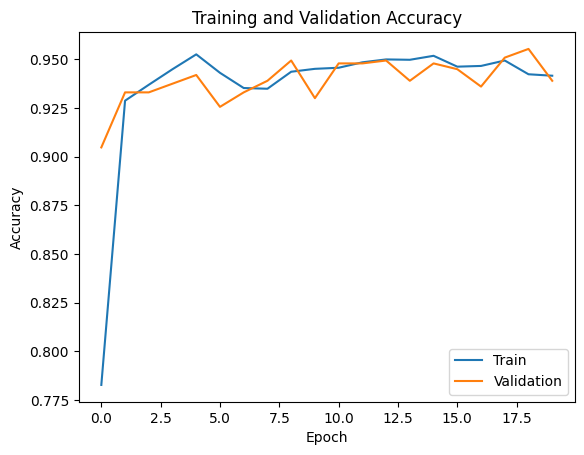

In [8]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

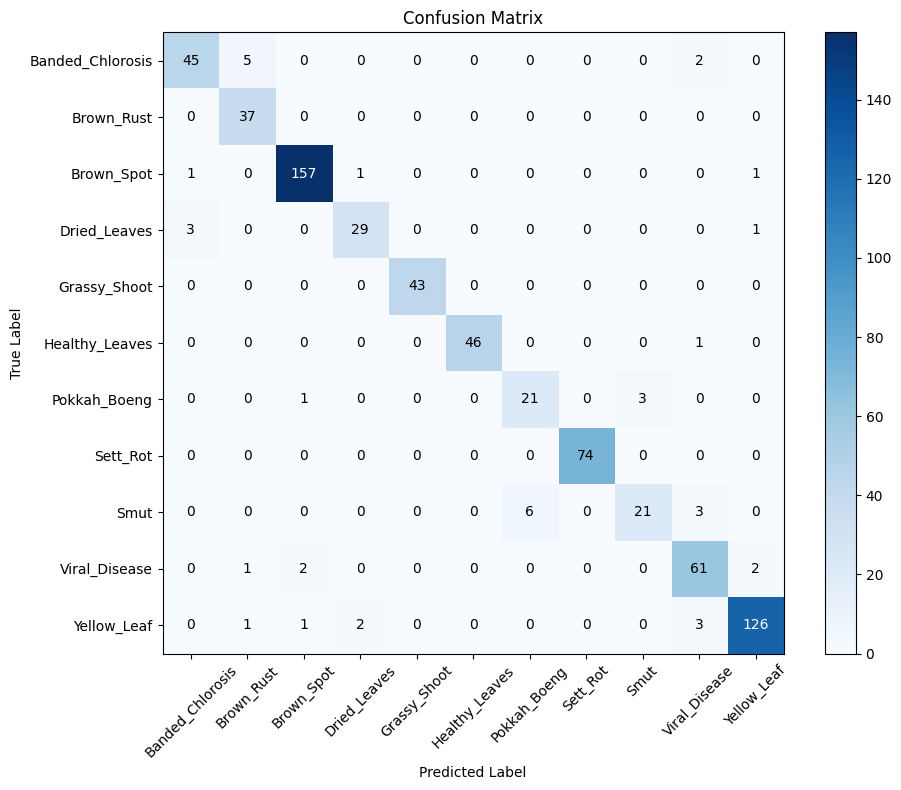

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       0.93      0.76      0.84        50
      Brown_Rust       0.79      1.00      0.88        33
      Brown_Spot       0.99      0.98      0.99       171
    Dried_Leaves       0.88      0.94      0.91        31
    Grassy_Shoot       1.00      1.00      1.00        38
  Healthy_Leaves       1.00      1.00      1.00        43
    Pokkah_Boeng       0.80      0.89      0.84        27
        Sett_Rot       1.00      1.00      1.00        79
            Smut       0.87      0.69      0.77        29
   Viral_Disease       0.87      0.94      0.90        62
     Yellow_Leaf       0.97      0.95      0.96       137

        accuracy                           0.94       700
       macro avg       0.92      0.92      0.92       700
    weighted avg       0.95      0.94      0.94       700



In [11]:
from tensorflow.keras.applications import VGG16

# Get the number of classes and set up the base model
num_classes = len(dataset.class_names)

def build_pretrained_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(iz, iz, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classifier on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


model = build_pretrained_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = 20
)

Epoch 1/20
168/168 [==============================] - 27s 157ms/step - loss: 1.9510 - accuracy: 0.4451 - val_loss: 0.9882 - val_accuracy: 0.6473
Epoch 2/20
168/168 [==============================] - 26s 154ms/step - loss: 0.7660 - accuracy: 0.7299 - val_loss: 0.6334 - val_accuracy: 0.7842
Epoch 3/20
168/168 [==============================] - 26s 153ms/step - loss: 0.5202 - accuracy: 0.8326 - val_loss: 0.4649 - val_accuracy: 0.8646
Epoch 4/20
168/168 [==============================] - 26s 153ms/step - loss: 0.4166 - accuracy: 0.8650 - val_loss: 0.3909 - val_accuracy: 0.8795
Epoch 5/20
168/168 [==============================] - 26s 154ms/step - loss: 0.3521 - accuracy: 0.8876 - val_loss: 0.3198 - val_accuracy: 0.8958
Epoch 6/20
168/168 [==============================] - 26s 153ms/step - loss: 0.3083 - accuracy: 0.9040 - val_loss: 0.2941 - val_accuracy: 0.8973
Epoch 7/20
168/168 [==============================] - 26s 154ms/step - loss: 0.2771 - accuracy: 0.9152 - val_loss: 0.2920 - val_ac

In [12]:
scores = model.evaluate(testing_ds)
scores

22/22 [==============================] - 6s 116ms/step - loss: 0.1780 - accuracy: 0.9314


[0.17795111238956451, 0.9314285516738892]

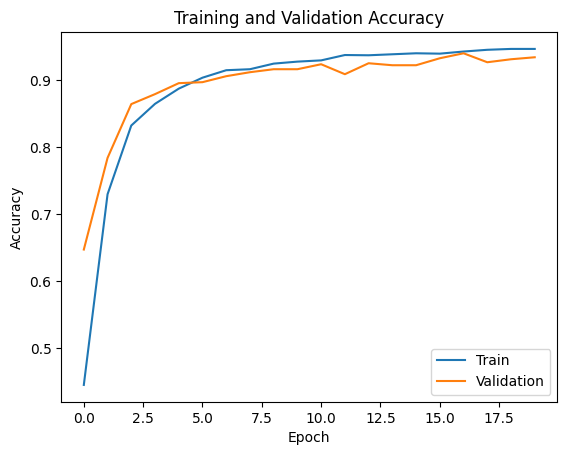

In [13]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

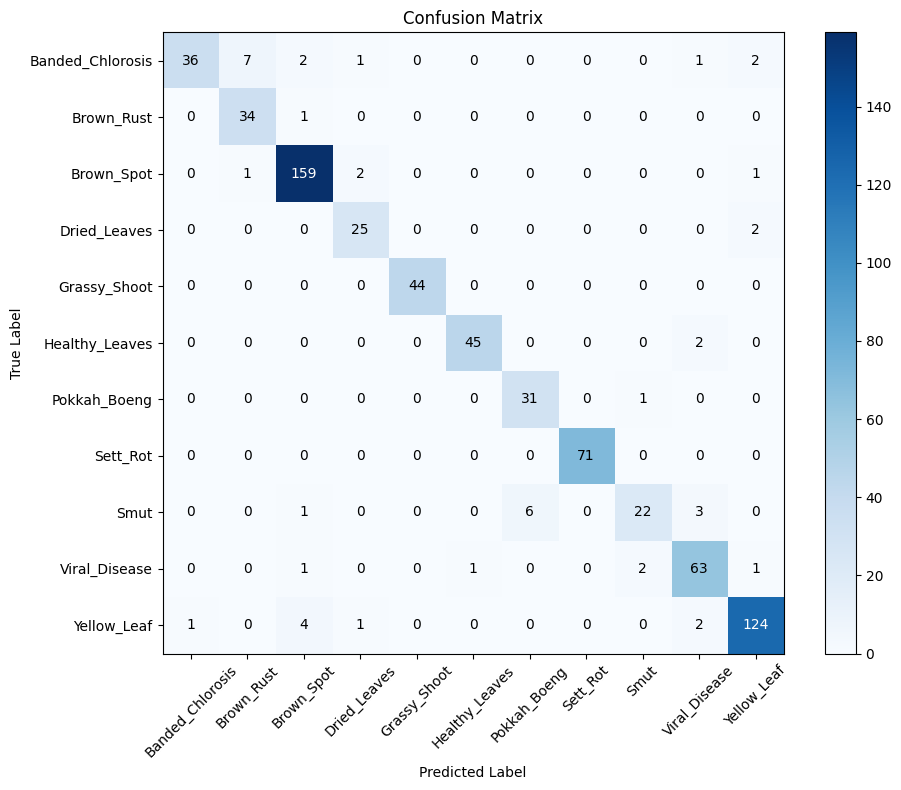

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       0.97      0.74      0.84        47
      Brown_Rust       0.81      0.97      0.89        36
      Brown_Spot       0.95      0.97      0.96       176
    Dried_Leaves       0.84      0.96      0.90        27
    Grassy_Shoot       1.00      1.00      1.00        36
  Healthy_Leaves       1.00      0.98      0.99        45
    Pokkah_Boeng       0.83      0.97      0.90        31
        Sett_Rot       1.00      1.00      1.00        75
            Smut       0.88      0.72      0.79        32
   Viral_Disease       0.89      0.93      0.91        67
     Yellow_Leaf       0.95      0.91      0.93       128

        accuracy                           0.93       700
       macro avg       0.92      0.92      0.92       700
    weighted avg       0.94      0.93      0.93       700



In [16]:
from tensorflow.keras.applications import VGG16

# Get the number of classes and set up the base model
num_classes = len(dataset.class_names)

def build_pretrained_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(iz, iz, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classifier on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


model = build_pretrained_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = 20
)

Epoch 1/20
168/168 [==============================] - 27s 155ms/step - loss: 0.9221 - accuracy: 0.7256 - val_loss: 0.3577 - val_accuracy: 0.9003
Epoch 2/20
168/168 [==============================] - 26s 153ms/step - loss: 0.3140 - accuracy: 0.9003 - val_loss: 0.2455 - val_accuracy: 0.9152
Epoch 3/20
168/168 [==============================] - 26s 153ms/step - loss: 0.2230 - accuracy: 0.9297 - val_loss: 0.1750 - val_accuracy: 0.9449
Epoch 4/20
168/168 [==============================] - 26s 153ms/step - loss: 0.1728 - accuracy: 0.9394 - val_loss: 0.1718 - val_accuracy: 0.9420
Epoch 5/20
168/168 [==============================] - 26s 154ms/step - loss: 0.1549 - accuracy: 0.9431 - val_loss: 0.1565 - val_accuracy: 0.9464
Epoch 6/20
168/168 [==============================] - 26s 156ms/step - loss: 0.1483 - accuracy: 0.9455 - val_loss: 0.1557 - val_accuracy: 0.9494
Epoch 7/20
168/168 [==============================] - 26s 156ms/step - loss: 0.1314 - accuracy: 0.9464 - val_loss: 0.1295 - val_ac

In [17]:
scores = model.evaluate(testing_ds)
scores

22/22 [==============================] - 6s 118ms/step - loss: 0.1216 - accuracy: 0.9414


[0.12158088386058807, 0.941428542137146]

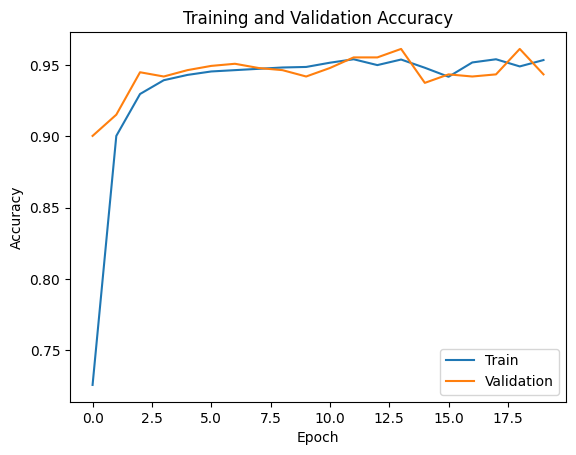

In [18]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

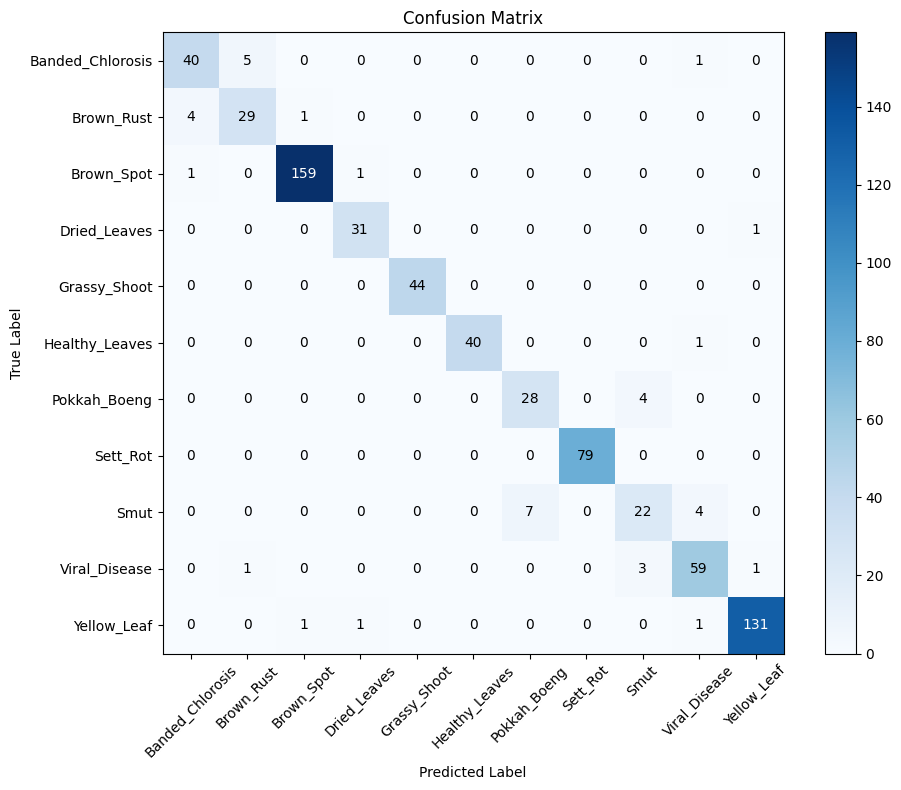

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       0.93      0.84      0.88        50
      Brown_Rust       0.84      0.91      0.88        35
      Brown_Spot       0.99      0.99      0.99       170
    Dried_Leaves       0.93      0.96      0.95        28
    Grassy_Shoot       1.00      1.00      1.00        38
  Healthy_Leaves       1.00      0.98      0.99        45
    Pokkah_Boeng       0.74      0.85      0.79        27
        Sett_Rot       1.00      1.00      1.00        79
            Smut       0.71      0.67      0.69        33
   Viral_Disease       0.90      0.91      0.90        67
     Yellow_Leaf       0.98      0.98      0.98       128

        accuracy                           0.94       700
       macro avg       0.91      0.92      0.91       700
    weighted avg       0.95      0.94      0.94       700

